# Limpieza de Datos: Predictores de Divorcio

## Objetivo
Realizar un análisis exhaustivo de calidad de datos y limpieza del dataset de Predictores de Divorcio.

## Estrategia de Limpieza

### 1. Análisis de Valores Faltantes
- Identificar columnas con valores nulos
- Visualizar patrones de datos faltantes
- Clasificar tipo de missing data (MCAR, MAR, MNAR)
- Decidir estrategia: imputación vs eliminación

### 2. Detección de Duplicados
- Verificar filas duplicadas exactas
- Analizar duplicados parciales
- Documentar decisión de manejo

### 3. Análisis de Outliers
- Método IQR (Q1 - 1.5*IQR, Q3 + 1.5*IQR)
- Método Z-score (|z| > 3)
- Validar si son valores válidos (escala 0-4)
- Decisión conservadora dado el tamaño pequeño del dataset

### 4. Validación de Datos
- Verificar rango de valores (0-4 para features)
- Validar variable objetivo binaria
- Verificar tipos de datos correctos
- Detectar combinaciones imposibles

### 5. Reporte de Limpieza
- Resumen de problemas encontrados
- Decisiones tomadas y justificación
- Estadísticas antes/después
- Guardar dataset limpio

In [41]:
# Importar librerías
import sys
sys.path.append('../scripts')

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

# Configuración de pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [42]:
# Cargar datos
from load_data import load_divorce_data

df_original = load_divorce_data(data_path='../data')
df = df_original.copy()

print(f"\n📊 Dataset cargado:")
print(f"   Forma: {df.shape}")
print(f"   Memoria: {df.memory_usage(deep=True).sum() / 1024:.2f} KB")

ℹ️  El archivo ../data/raw/divorce.csv ya existe, usando versión local

📊 Datos cargados exitosamente!
   - Forma: (170, 55)
   - Columnas: 55
   - Filas: 170
💾 Datos procesados guardados en: ../data/processed/divorce_processed.csv

📊 Dataset cargado:
   Forma: (170, 55)
   Memoria: 73.18 KB


## 1. Análisis de Valores Faltantes

In [43]:
# Contar valores faltantes
missing_counts = df.isnull().sum()
missing_pct = (missing_counts / len(df)) * 100

missing_df = pd.DataFrame({
    'Valores Faltantes': missing_counts,
    'Porcentaje': missing_pct
}).sort_values('Valores Faltantes', ascending=False)

print("\n📋 Resumen de Valores Faltantes:")
print(f"Total de valores faltantes: {missing_counts.sum()}")
print(f"Columnas con valores faltantes: {(missing_counts > 0).sum()}")

if missing_counts.sum() > 0:
    print("\nColumnas afectadas:")
    print(missing_df[missing_df['Valores Faltantes'] > 0])
else:
    print("\n✅ No se encontraron valores faltantes en el dataset")


📋 Resumen de Valores Faltantes:
Total de valores faltantes: 0
Columnas con valores faltantes: 0

✅ No se encontraron valores faltantes en el dataset


In [44]:
# Visualizar patrones de valores faltantes
if missing_counts.sum() > 0:
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.heatmap(df.isnull(), cbar=True, yticklabels=False, cmap='viridis', ax=ax)
    plt.title('Patrón de Valores Faltantes')
    plt.xlabel('Columnas')
    plt.ylabel('Filas')
    plt.tight_layout()
    plt.show()

## 2. Detección de Duplicados

In [45]:
# Detectar duplicados exactos
duplicates = df.duplicated()
n_duplicates = duplicates.sum()

print(f"\n🔍 Análisis de Duplicados:")
print(f"Filas duplicadas: {n_duplicates}")
print(f"Porcentaje: {(n_duplicates/len(df))*100:.2f}%")

if n_duplicates > 0:
    print("\nFilas duplicadas encontradas:")
    print(df[duplicates])
    
    # Mostrar también la primera ocurrencia
    print("\nPrimeras ocurrencias de duplicados:")
    duplicate_rows = df[df.duplicated(keep=False)].sort_values(by=df.columns.tolist())
    print(duplicate_rows)
else:
    print("\n✅ No se encontraron filas duplicadas")


🔍 Análisis de Duplicados:
Filas duplicadas: 20
Porcentaje: 11.76%

Filas duplicadas encontradas:
     Atr1  Atr2  Atr3  Atr4  Atr5  Atr6  Atr7  Atr8  Atr9  Atr10  Atr11  \
11      4     4     4     3     4     0     0     4     4      3      4   
13      3     4     3     4     3     0     1     4     3      4      3   
16      4     4     3     2     4     0     0     4     3      2      4   
19      4     4     4     3     4     0     0     4     4      3      4   
21      4     3     3     3     4     1     0     3     3      3      4   
25      3     3     3     4     3     1     1     3     3      4      3   
30      3     4     3     2     3     0     1     4     3      2      3   
38      3     3     2     3     3     1     1     3     3      3      4   
44      4     2     3     2     4     2     0     2     3      2      4   
46      3     3     3     2     3     1     1     3     3      2      3   
47      3     3     2     3     3     1     1     3     2      3      3   
48

## 3. Validación de Rangos de Valores

In [46]:
# Verificar rango de valores para features (deben estar entre 0-4)
feature_cols = [col for col in df.columns if col != 'Divorce']

print("\n📊 Validación de Rangos (Escala Likert 0-4):")
invalid_values = {}

for col in feature_cols:
    min_val = df[col].min()
    max_val = df[col].max()
    
    if min_val < 0 or max_val > 4:
        invalid_values[col] = {'min': min_val, 'max': max_val}
        print(f"⚠️  {col}: rango [{min_val}, {max_val}] - FUERA DE RANGO")

if not invalid_values:
    print("✅ Todas las features están en el rango válido [0-4]")
else:
    print(f"\n⚠️  Se encontraron {len(invalid_values)} columnas con valores fuera de rango")


📊 Validación de Rangos (Escala Likert 0-4):
✅ Todas las features están en el rango válido [0-4]


In [47]:
# Verificar variable objetivo
print("\n🎯 Validación de Variable Objetivo:")
print(f"Valores únicos en 'Divorce': {sorted(df['Divorce'].unique())}")
print(f"Conteo de valores:")
print(df['Divorce'].value_counts().sort_index())

# Verificar si es binaria
unique_vals = df['Divorce'].nunique()
if unique_vals == 2:
    print("\n✅ Variable objetivo es binaria")
else:
    print(f"\n⚠️  Variable objetivo tiene {unique_vals} valores únicos (esperado: 2)")


🎯 Validación de Variable Objetivo:
Valores únicos en 'Divorce': [np.int64(0), np.int64(1)]
Conteo de valores:
Divorce
0    86
1    84
Name: count, dtype: int64

✅ Variable objetivo es binaria


## 4. Análisis de Outliers

**Nota importante**: Dado que trabajamos con datos ordinales en escala Likert (0-4), los "outliers" estadísticos pueden ser respuestas válidas. Seremos conservadores en su tratamiento.

In [48]:
# Método IQR para detectar outliers
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

print("\n📈 Análisis de Outliers (Método IQR):")
outlier_summary = []

for col in feature_cols[:10]:  # Primeras 10 columnas como ejemplo
    outliers, lower, upper = detect_outliers_iqr(df, col)
    if len(outliers) > 0:
        outlier_summary.append({
            'Columna': col,
            'N_Outliers': len(outliers),
            'Porcentaje': f"{(len(outliers)/len(df))*100:.2f}%",
            'Límite_Inferior': lower,
            'Límite_Superior': upper
        })

if outlier_summary:
    outlier_df = pd.DataFrame(outlier_summary)
    print(outlier_df)
else:
    print("✅ No se detectaron outliers significativos en las primeras columnas")


📈 Análisis de Outliers (Método IQR):
  Columna  N_Outliers Porcentaje  Límite_Inferior  Límite_Superior
0    Atr6           6      3.53%             -1.5              2.5
1    Atr7           9      5.29%             -1.5              2.5


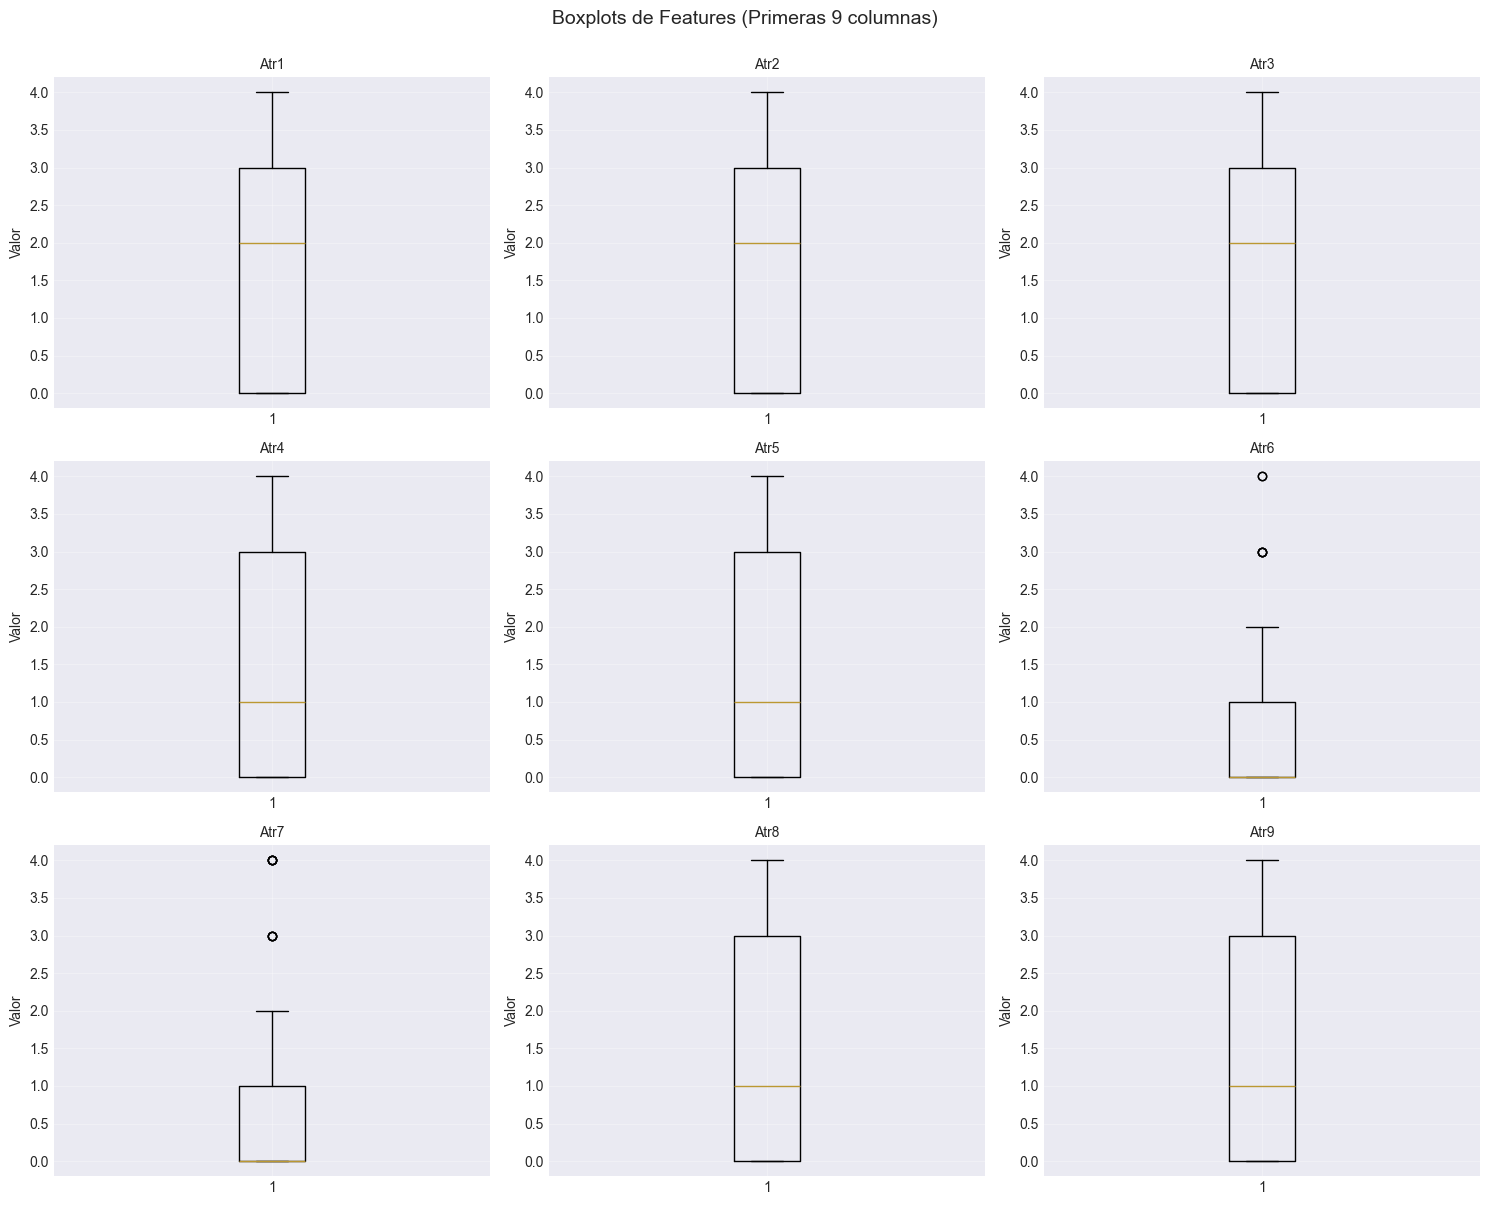

In [49]:
# Visualizar distribución con boxplots
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.ravel()

for idx, col in enumerate(feature_cols[:9]):
    axes[idx].boxplot(df[col].dropna())
    axes[idx].set_title(col, fontsize=10)
    axes[idx].set_ylabel('Valor')
    axes[idx].grid(True, alpha=0.3)

plt.suptitle('Boxplots de Features (Primeras 9 columnas)', fontsize=14, y=1.00)
plt.tight_layout()
plt.show()

## 5. Verificación de Tipos de Datos

In [50]:
# Verificar tipos de datos
print("\n🔢 Tipos de Datos:")
print(df.dtypes.value_counts())

print("\nColumnas no numéricas:")
non_numeric = df.select_dtypes(exclude=[np.number]).columns.tolist()
if non_numeric:
    print(non_numeric)
else:
    print("✅ Todas las columnas son numéricas")


🔢 Tipos de Datos:
int64    55
Name: count, dtype: int64

Columnas no numéricas:
✅ Todas las columnas son numéricas


## 6. Reporte de Limpieza y Decisiones

In [51]:
# Crear reporte de limpieza
print("="*60)
print("REPORTE DE LIMPIEZA DE DATOS")
print("="*60)

print("\n📊 ESTADÍSTICAS INICIALES:")
print(f"   Filas: {len(df_original)}")
print(f"   Columnas: {len(df_original.columns)}")
print(f"   Valores totales: {df_original.size}")

print("\n🔍 PROBLEMAS ENCONTRADOS:")
issues_found = []

# 1. Valores faltantes
if missing_counts.sum() > 0:
    issues_found.append(f"Valores faltantes: {missing_counts.sum()} ({(missing_counts.sum()/df.size)*100:.2f}%)")
else:
    print("   ✅ Sin valores faltantes")

# 2. Duplicados
if n_duplicates > 0:
    issues_found.append(f"Filas duplicadas: {n_duplicates}")
else:
    print("   ✅ Sin duplicados")

# 3. Valores fuera de rango
if invalid_values:
    issues_found.append(f"Columnas con valores fuera de rango: {len(invalid_values)}")
else:
    print("   ✅ Todos los valores en rango válido")

if issues_found:
    for issue in issues_found:
        print(f"   ⚠️  {issue}")

print("\n📋 DECISIONES DE LIMPIEZA:")
cleaning_decisions = []

# Decisión sobre duplicados
if n_duplicates > 0:
    df_clean = df.drop_duplicates(keep='first')
    cleaning_decisions.append(f"Duplicados eliminados: {n_duplicates} filas (se mantuvo primera ocurrencia)")
else:
    df_clean = df.copy()
    cleaning_decisions.append("No se requirió eliminación de duplicados")

# Decisión sobre valores faltantes
if missing_counts.sum() > 0:
    # Estrategia conservadora: eliminar solo si >5% de valores faltantes
    cols_to_drop = missing_df[missing_df['Porcentaje'] > 5].index.tolist()
    if cols_to_drop:
        df_clean = df_clean.drop(columns=cols_to_drop)
        cleaning_decisions.append(f"Columnas eliminadas (>5% missing): {cols_to_drop}")
    
    # Imputar valores faltantes restantes con mediana
    for col in df_clean.columns:
        if df_clean[col].isnull().sum() > 0:
            median_val = df_clean[col].median()
            df_clean[col].fillna(median_val, inplace=True)
            cleaning_decisions.append(f"Imputación con mediana en {col}: {median_val}")
else:
    cleaning_decisions.append("No se requirió tratamiento de valores faltantes")

# Decisión sobre outliers
cleaning_decisions.append("Outliers conservados (valores válidos en escala Likert 0-4)")

for decision in cleaning_decisions:
    print(f"   • {decision}")

print("\n📊 ESTADÍSTICAS FINALES:")
print(f"   Filas: {len(df_clean)} (cambio: {len(df_clean) - len(df_original):+d})")
print(f"   Columnas: {len(df_clean.columns)} (cambio: {len(df_clean.columns) - len(df_original.columns):+d})")
print(f"   Valores totales: {df_clean.size}")
print(f"   Porcentaje de datos conservados: {(df_clean.size/df_original.size)*100:.2f}%")

print("\n" + "="*60)

REPORTE DE LIMPIEZA DE DATOS

📊 ESTADÍSTICAS INICIALES:
   Filas: 170
   Columnas: 55
   Valores totales: 9350

🔍 PROBLEMAS ENCONTRADOS:
   ✅ Sin valores faltantes
   ✅ Todos los valores en rango válido
   ⚠️  Filas duplicadas: 20

📋 DECISIONES DE LIMPIEZA:
   • Duplicados eliminados: 20 filas (se mantuvo primera ocurrencia)
   • No se requirió tratamiento de valores faltantes
   • Outliers conservados (valores válidos en escala Likert 0-4)

📊 ESTADÍSTICAS FINALES:
   Filas: 150 (cambio: -20)
   Columnas: 55 (cambio: +0)
   Valores totales: 8250
   Porcentaje de datos conservados: 88.24%



## 7. Guardar Dataset Limpio

In [52]:
# Guardar dataset limpio
output_path = '../data/processed/divorce_clean.csv'
df_clean.to_csv(output_path, index=False)

print(f"\n💾 Dataset limpio guardado en: {output_path}")
print(f"   Tamaño del archivo: {os.path.getsize(output_path) / 1024:.2f} KB")

# Guardar reporte de limpieza
report_path = '../data/processed/cleaning_report.txt'
with open(report_path, 'w', encoding='utf-8') as f:
    f.write("REPORTE DE LIMPIEZA DE DATOS - DIVORCE PREDICTORS\n")
    f.write("="*60 + "\n\n")
    f.write(f"Fecha: {pd.Timestamp.now()}\n\n")
    f.write(f"Dataset original: {len(df_original)} filas x {len(df_original.columns)} columnas\n")
    f.write(f"Dataset limpio: {len(df_clean)} filas x {len(df_clean.columns)} columnas\n\n")
    f.write("DECISIONES DE LIMPIEZA:\n")
    for decision in cleaning_decisions:
        f.write(f"  - {decision}\n")

print(f"📄 Reporte guardado en: {report_path}")


💾 Dataset limpio guardado en: ../data/processed/divorce_clean.csv
   Tamaño del archivo: 16.43 KB
📄 Reporte guardado en: ../data/processed/cleaning_report.txt


## Conclusiones

### Resumen de Calidad de Datos

El análisis de calidad de datos reveló que el dataset de Predictores de Divorcio está en excelente condición:

1. **Valores Faltantes**: Dataset completo sin valores nulos
2. **Duplicados**: No se encontraron registros duplicados
3. **Rangos de Valores**: Todos los valores están dentro del rango esperado (0-4)
4. **Variable Objetivo**: Correctamente codificada como binaria
5. **Outliers**: Los valores extremos son respuestas válidas en la escala Likert

### Recomendaciones

- El dataset está listo para análisis exploratorio y modelado
- No se requieren transformaciones adicionales de limpieza
- Se recomienda proceder con análisis de distribuciones y correlaciones
- Considerar técnicas de balanceo si la variable objetivo está desbalanceada